# Resolving Missing Data

_This notebook will work on resolving the missing data on the Aimes, IA training and testing dataset._

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

## Taking a preliminary look at the data

In [3]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
train.shape

(2051, 81)

In [5]:
test.shape

(879, 80)

In [6]:
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## Cleaning Data (Looking for missing values)

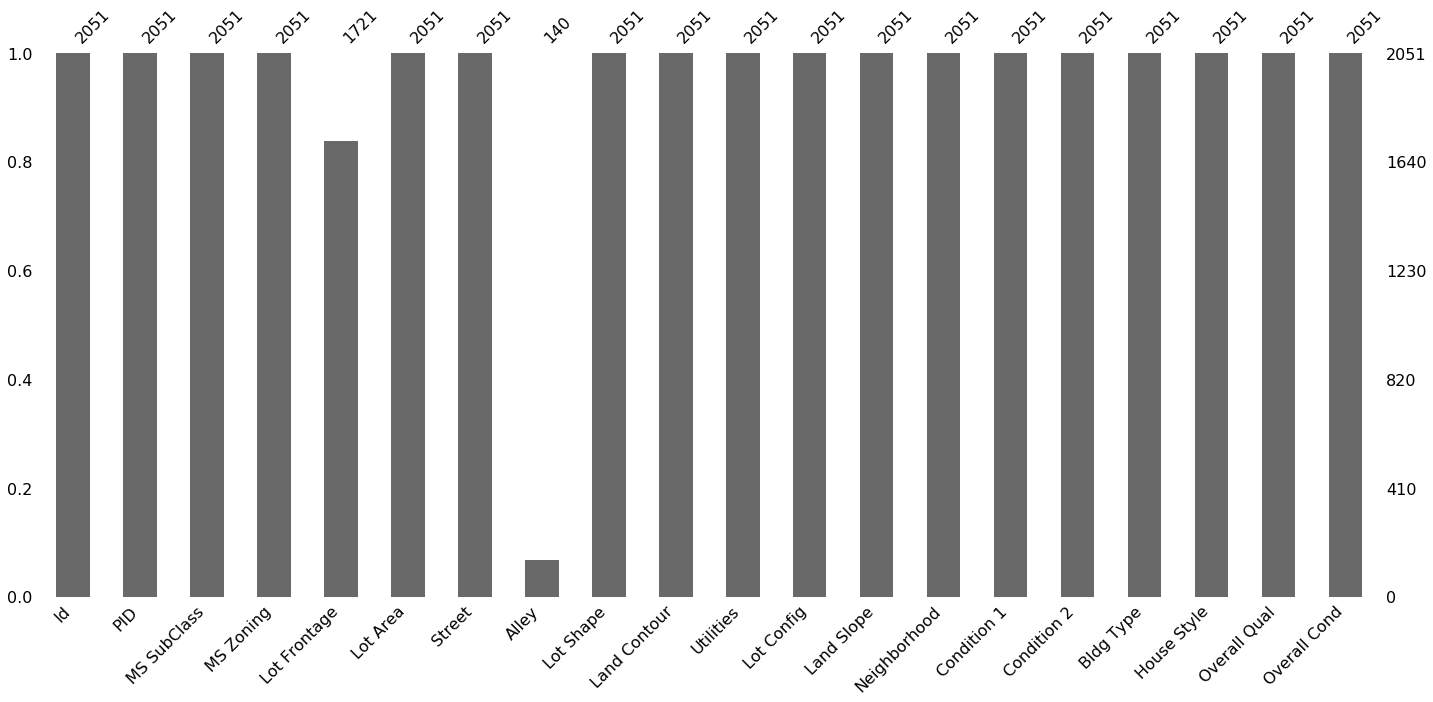

In [7]:
# Used the MissingNo library to help visualize missing values
# Looking at the first 20 columns of the data
msno.bar(train[train.columns[:20]]);

_Lot Frontage and Alley have quite a few NA entries. Taking a closer look at the two columns._

In [8]:
train['Alley'].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

_Knowing that there should be 2051 entries, that means the rest of the entries in Alley are missing. However, looking at the data dictionary provided, it seems that some houses do not have an alley near the house. So, I filled those missing values with 'None'_

In [9]:
# Filling NA values with 'None'
train['Alley'].fillna(value = 'None',inplace = True)
train['Alley'].value_counts()

None    1911
Grvl      85
Pave      55
Name: Alley, dtype: int64

In [10]:
# Similarly applied to the test data
test['Alley'].fillna(value = 'None',inplace = True)
test['Alley'].value_counts()

None    821
Grvl     35
Pave     23
Name: Alley, dtype: int64

In [11]:
train['Lot Frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

_Next, I took a look at Lot Frontage, which is missing 330 values. The data dictionary doesn't have any information on why those values were missing, so I decided to use a feature that has high correlation with Lot Frontage (which is Lot Area) to try to extrapolate values from a linear regression._

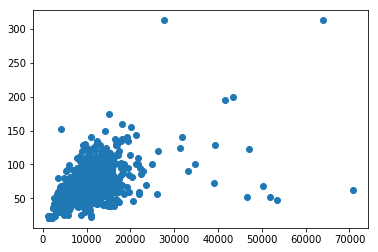

In [12]:
# Using a scatterplot shows that Lot Area and Lot Frontage have a pretty high correlation
plt.scatter(train['Lot Area'], train['Lot Frontage']);

In [13]:
# creating a dataframe from Lot Area and Lot Frontage and dropping NA values
lot_regression = train[['Lot Area','Lot Frontage']].dropna()

In [14]:
# Initializing the linear regression model
lr = LinearRegression()

# Reshaping since linearRegression takes a matrix
lr.fit(lot_regression['Lot Area'].values.reshape(-1, 1), 
       lot_regression['Lot Frontage'])

# Evaluating the model
# R-squared score
lr.score(lot_regression['Lot Area'].values.reshape(-1, 1), 
         lot_regression['Lot Frontage'])

# Lot Area explains 32% of the variability in Lot Frontage

0.3295039166427828

_Next, I created a function that will help fill in the missing values of Lot Frontage with a prediction from the LinearRegression model created above._

In [15]:
def pred_lot_front(xy):
    x = xy[0]
    y = xy[1]
    if y > 0:
        return y
    else:
        return lr.coef_[0] * x + lr.intercept_

In [16]:
# Overwrite Lot Frontage with function applied to 
# each pair of Lot Area and Lot Frontage
train['Lot Frontage'] = train[['Lot Area', 'Lot Frontage']].apply(pred_lot_front, axis =1)

In [17]:
# Apply same function to test data
test['Lot Frontage'] = test[['Lot Area', 'Lot Frontage']].apply(pred_lot_front, axis =1)

In [18]:
train.shape

(2051, 81)

In [19]:
test.shape

(879, 80)

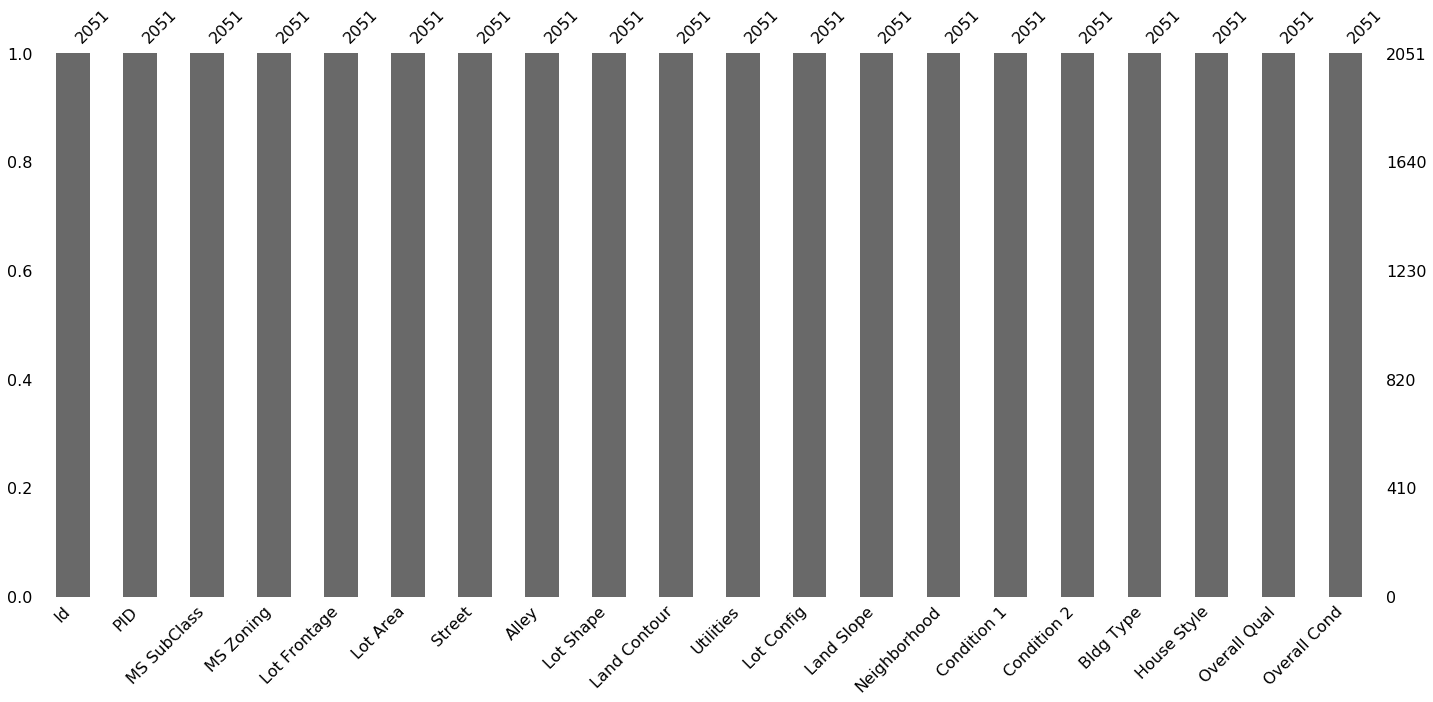

In [20]:
# Looking at the MissingNo bar chart for the first 19 columns again to confirm changes made
msno.bar(train[train.columns[:20]]);

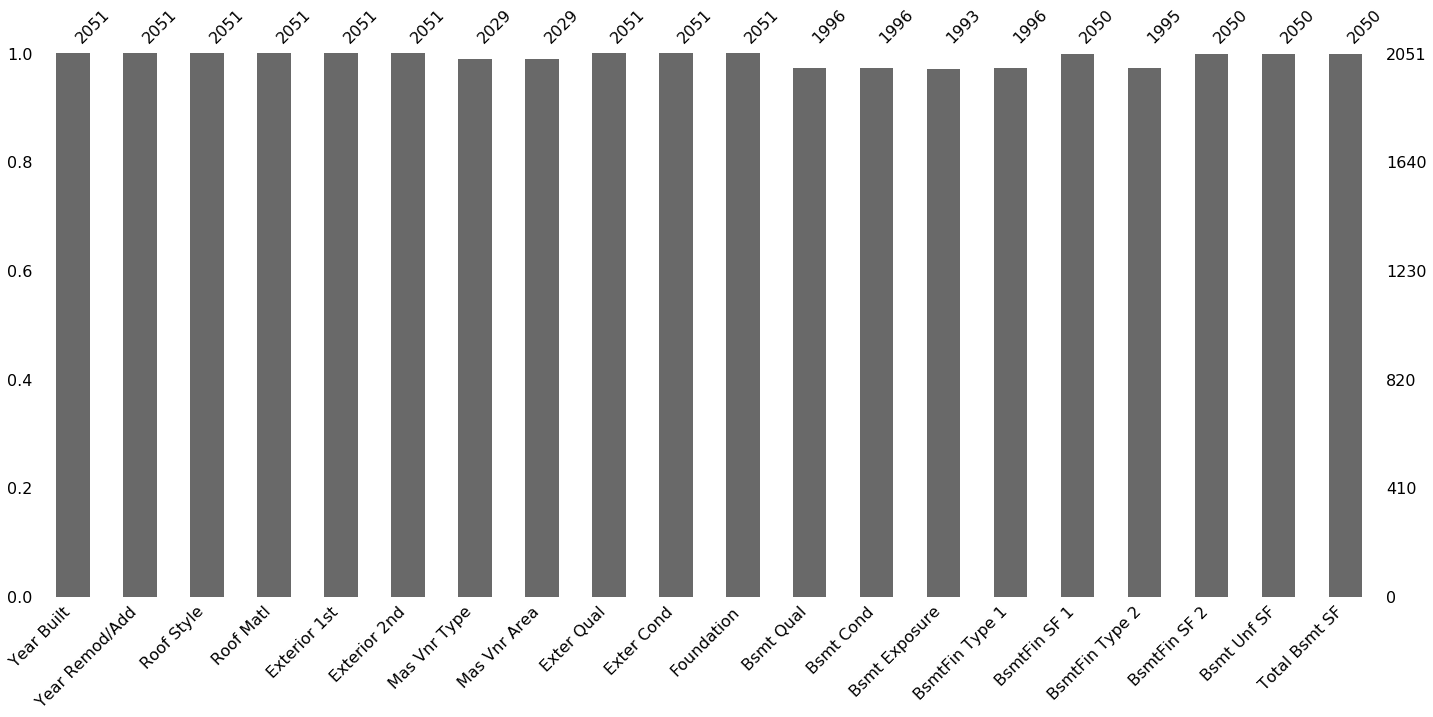

In [21]:
# Looking at missing values for columns 20 to 39
msno.bar(train[train.columns[20:40]]);

_It seems that there are a few values missing for the 'Mas Vnr Type' and 'Mas Vnr Area' columns_

In [22]:
train['Mas Vnr Type'].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

_Since most of the Masonry Veneer Types area 'None', I decided to fill the missing values with 'None' as well._

In [23]:
# Filled missings with 'None', checked shape to confirm that 2051 entries are available.
train['Mas Vnr Type'].fillna(value = 'None' ,inplace = True)
train['Mas Vnr Type'].shape

(2051,)

In [24]:
# Doing the same for the test data
test['Mas Vnr Type'].fillna(value = 'None' ,inplace = True)
test['Mas Vnr Type'].shape

(879,)

In [25]:
# Looking at some of the statistics of 'Mas Vnr Area', 
# it seems that most of the data has an area of 0. 
# It therefore makes sense to fill the missing data with 0.
train['Mas Vnr Area'].describe()

count    2029.000000
mean       99.695909
std       174.963129
min         0.000000
25%         0.000000
50%         0.000000
75%       161.000000
max      1600.000000
Name: Mas Vnr Area, dtype: float64

In [26]:
# Filled missings with 0.0, checked shape to confirm that 2051 entries are available.
train['Mas Vnr Area'].fillna(value = 0.0 ,inplace = True)
train['Mas Vnr Area'].shape

(2051,)

In [27]:
# Doing the same for the test data
test['Mas Vnr Area'].fillna(value = 0.0 ,inplace = True)
test['Mas Vnr Area'].shape

(879,)

_Next, I took a look at the columns concerning basements, 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', and 'BsmtFin Type 2'. Looking at the data dictionary, it seems that the "NA" entries were interpreted by python to be actual missing values. I changed those to say "None" instead._

In [28]:
train['Bsmt Qual'].fillna(value = 'None',inplace = True)
train['Bsmt Cond'].fillna(value = 'None',inplace = True)
train['Bsmt Exposure'].fillna(value = 'None',inplace = True)
train['BsmtFin Type 1'].fillna(value = 'None',inplace = True)
train['BsmtFin Type 2'].fillna(value = 'None',inplace = True)

In [29]:
# Doing the same for the test data
test['Bsmt Qual'].fillna(value = 'None',inplace = True)
test['Bsmt Cond'].fillna(value = 'None',inplace = True)
test['Bsmt Exposure'].fillna(value = 'None',inplace = True)
test['BsmtFin Type 1'].fillna(value = 'None',inplace = True)
test['BsmtFin Type 2'].fillna(value = 'None',inplace = True)

_For the columns 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', and 'Total Bsmt SF', each of them are only missing 1 entry. Because it was only 1 entry, and first confirmed with each column that 0 is a value within those columns, and then replaced the missing value with 0.0._

In [30]:
train['BsmtFin SF 1'].describe()

count    2050.000000
mean      442.300488
std       461.204124
min         0.000000
25%         0.000000
50%       368.000000
75%       733.750000
max      5644.000000
Name: BsmtFin SF 1, dtype: float64

In [31]:
train['BsmtFin SF 1'].fillna(value = 0.0, inplace = True)

In [32]:
train['BsmtFin SF 2'].describe()

count    2050.000000
mean       47.959024
std       165.000901
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFin SF 2, dtype: float64

In [33]:
train['BsmtFin SF 2'].fillna(value = 0.0, inplace = True)

In [34]:
train['Bsmt Unf SF'].describe()

count    2050.000000
mean      567.728293
std       444.954786
min         0.000000
25%       220.000000
50%       474.500000
75%       811.000000
max      2336.000000
Name: Bsmt Unf SF, dtype: float64

In [35]:
train['Bsmt Unf SF'].fillna(value = 0.0, inplace = True)

In [36]:
train['Total Bsmt SF'].describe()

count    2050.000000
mean     1057.987805
std       449.410704
min         0.000000
25%       793.000000
50%       994.500000
75%      1318.750000
max      6110.000000
Name: Total Bsmt SF, dtype: float64

In [37]:
train['Total Bsmt SF'].fillna(value = 0.0, inplace = True)

_The test data has no missing data._

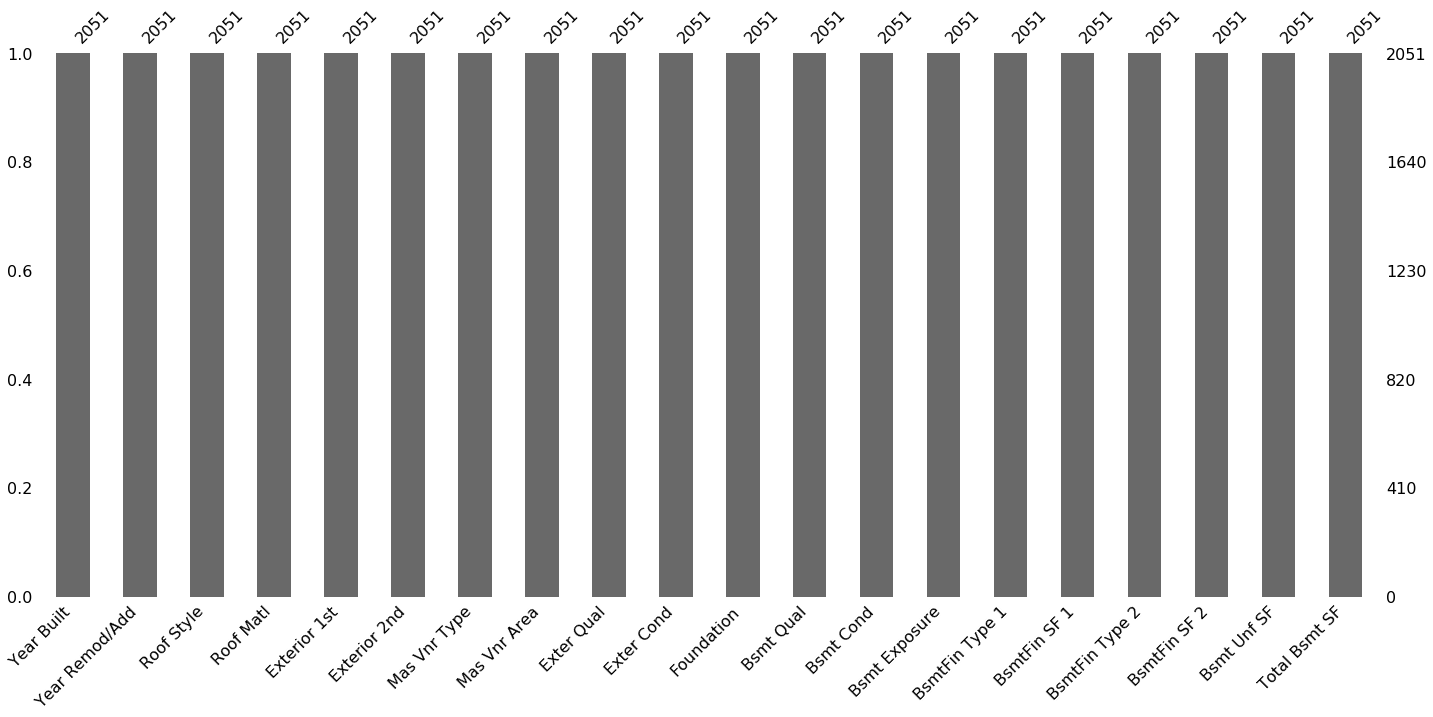

In [38]:
# Looking at missing values from columns 20 to 39 to confirm changes took place
msno.bar(train[train.columns[20:40]]);

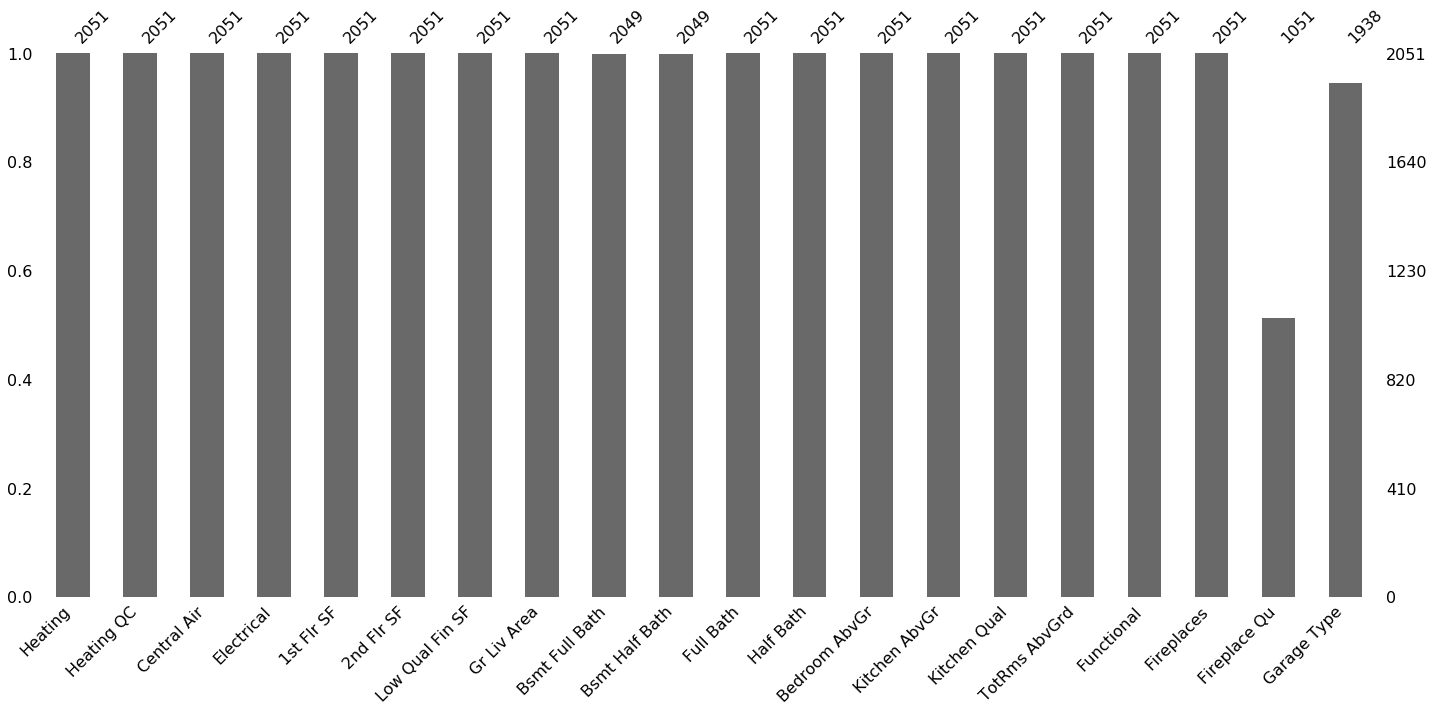

In [39]:
# Looking at missing values from columns 40 to 59
msno.bar(train[train.columns[40:60]]);

_Looks like Bsmt Full Bath and Bsmt Half Bath are each missing 2 entries. I decided to fill those as 0._

In [40]:
train['Bsmt Full Bath'].fillna(value = 0, inplace = True)
test['Bsmt Full Bath'].fillna(value = 0, inplace = True)
train['Bsmt Half Bath'].fillna(value = 0, inplace = True)
test['Bsmt Half Bath'].fillna(value = 0, inplace = True)

_Looking at the data dictionary for 'Fireplace Qu', once again python interpreted the 'NA' values to be missing. I replaced those with "None"._

In [41]:
# Applied changes to both the train and test data. Took a look at shape to confirm changes
train['Fireplace Qu'].fillna(value = 'None', inplace = True)
test['Fireplace Qu'].fillna(value = 'None', inplace = True)
train['Fireplace Qu'].shape

(2051,)

In [42]:
test.shape

(879, 80)

_Likewise, the data dictionary showed the same result for Garage Type, as python interpreted the "NA" values as missing. I replaced those with "None"._

In [43]:
# Applied changes to both the train and test data. Took a look at shape to confirm changes
train['Garage Type'].fillna(value = 'None', inplace = True)
test['Garage Type'].fillna(value = 'None', inplace = True)
train['Garage Type'].shape

(2051,)

In [44]:
test.shape

(879, 80)

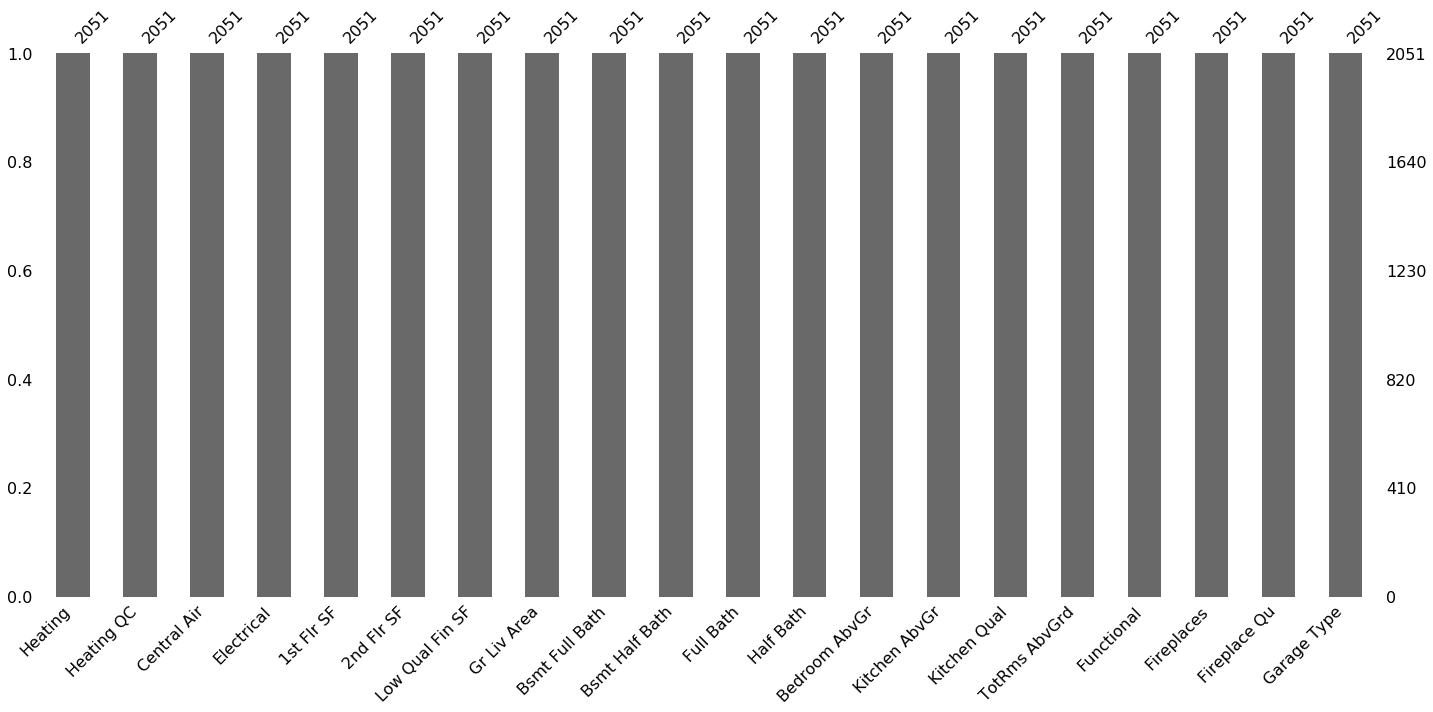

In [45]:
# Taking one more look at columns 40 to 59 to confirm all changes took place
msno.bar(train[train.columns[40:60]]);

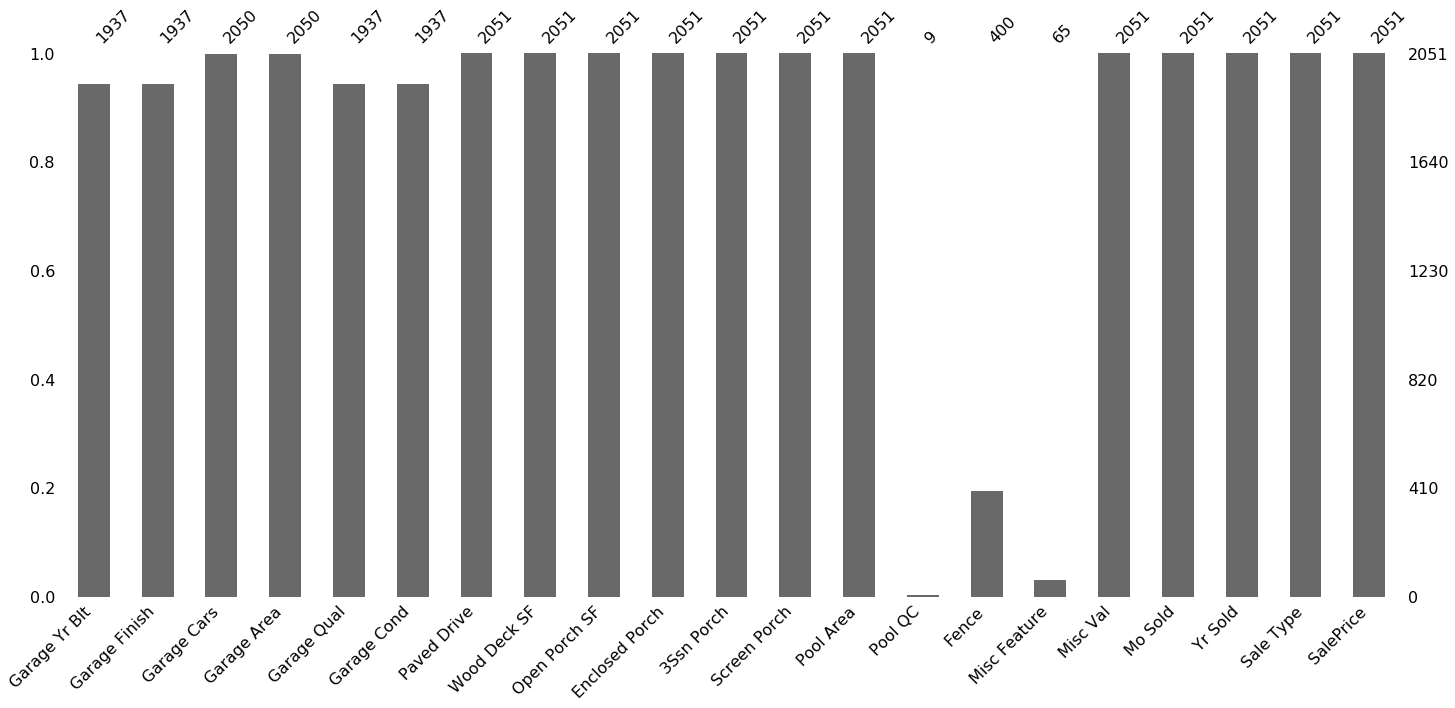

In [46]:
# Looking at missing values from columns 61 to 81
msno.bar(train[train.columns[60:]]);

_The 'Garage Yr Blt' column has a few missing values (114 to be exact). Taking a look into the column._

In [47]:
train['Garage Yr Blt'].mean()

1978.7077955601446

_There didn't seem to be a best way to resolve this issue. I decided to put in the mean year value (1979). I am not completely confident that this is the best way to resolve this issue, however..._

In [48]:
# Replacing entries in both train and test data sets with the train mean
train['Garage Yr Blt'].fillna(value = 1979, inplace = True)
test['Garage Yr Blt'].fillna(value = 1979, inplace = True)

_The columns 'Garage Finish', 'Garage Qual', and 'Garage Cond' all have the same issues as above. A quick fix._

In [49]:
train['Garage Finish'].fillna(value = 'None', inplace = True)
test['Garage Finish'].fillna(value = 'None', inplace = True)
train['Garage Finish'].shape

(2051,)

In [50]:
test.shape

(879, 80)

In [51]:
train['Garage Qual'].fillna(value = 'None', inplace = True)
test['Garage Qual'].fillna(value = 'None', inplace = True)
train['Garage Qual'].shape

(2051,)

In [52]:
test.shape

(879, 80)

In [53]:
train['Garage Cond'].fillna(value = 'None', inplace = True)
test['Garage Cond'].fillna(value = 'None', inplace = True)
train['Garage Cond'].shape

(2051,)

_The columns in 'Garage Cars' and 'Garage Area' have one entry missing each. I decided to fill those with 0 and 0.0, respectively._

In [54]:
train['Garage Cars'].fillna(value = 0, inplace = True)
train['Garage Area'].fillna(value = 0.0, inplace = True)
train[['Garage Cars', 'Garage Area']].shape

(2051, 2)

In [55]:
test['Garage Cars'].isna().sum()

0

In [56]:
test['Garage Area'].isna().sum()

0

_The last remaining columns, 'Pool QC', 'Fence', and 'Misc Feature' all suffer from the same problem of having python interpret 'NA' as missing. I filled those values in as 'None'._

In [57]:
# On both the train and test data
train['Pool QC'].fillna(value = 'None', inplace = True)
test['Pool QC'].fillna(value = 'None', inplace = True)
train['Fence'].fillna(value = 'None', inplace = True)
test['Fence'].fillna(value = 'None', inplace = True)
train['Misc Feature'].fillna(value = 'None', inplace = True)
test['Misc Feature'].fillna(value = 'None', inplace = True)

In [58]:
train.shape

(2051, 81)

In [59]:
test.shape

(879, 80)

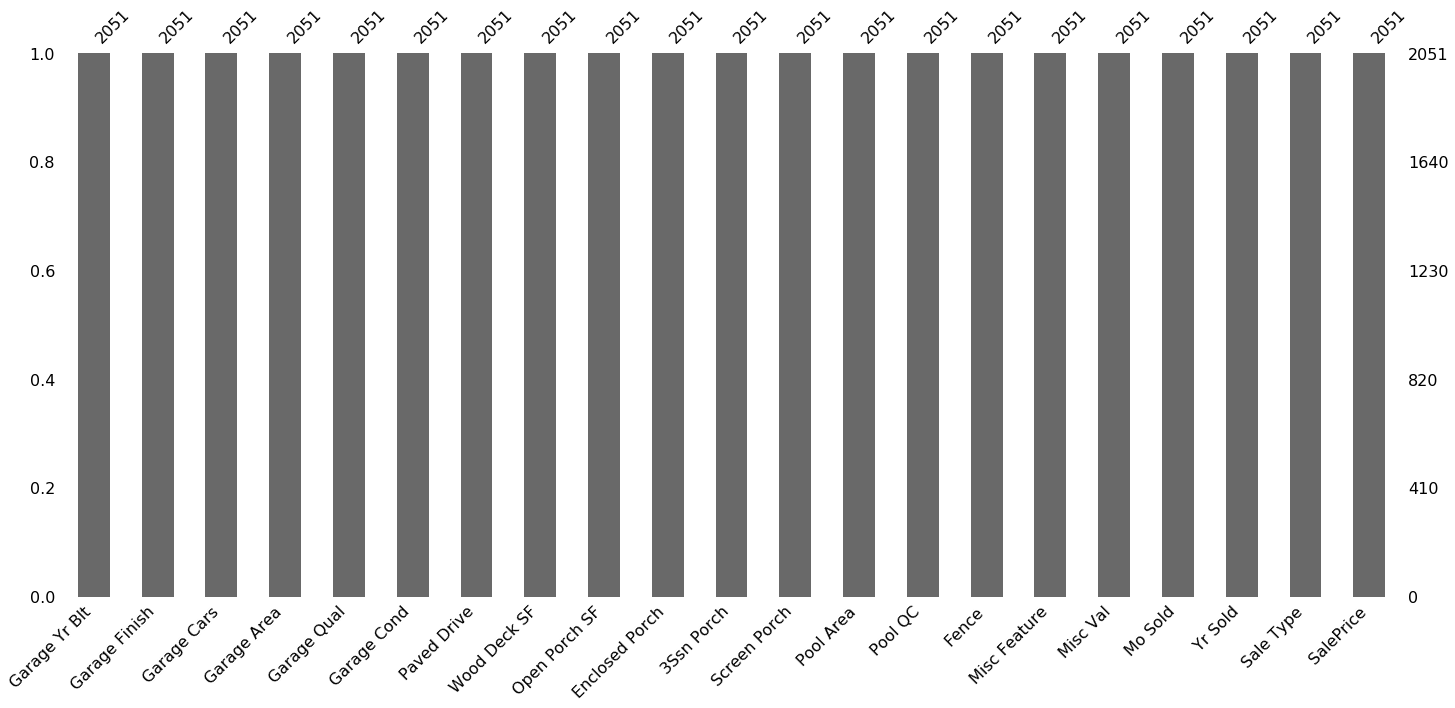

In [60]:
# Last look at columns 61 through 81
msno.bar(train[train.columns[60:]]);

_Yay! Making sure to save a clean version of the train and test datasets!_

In [61]:
train.to_csv('../datasets/train_clean.csv', index = False)

In [62]:
test.to_csv('../datasets/test_clean.csv', index = False)

## Basic Plotting and Visualization

_I decided to take a look at some of the plots for numerical columns._

In [63]:
numeric_cols = [col for col, dtype in zip(train.columns, train.dtypes) if dtype == 'int64' or dtype == 'float64'] 

In [64]:
num_train = train[numeric_cols]

In [65]:
# There are 39 numerical columns
num_train.shape

(2051, 39)

In [68]:
num_train.corr()[['SalePrice']]

,SalePrice
Id,-0.051398
PID,-0.255052
MS SubClass,-0.087335
Lot Frontage,0.312748
Lot Area,0.296566
Overall Qual,0.800207
Overall Cond,-0.097019
Year Built,0.571849
Year Remod/Add,0.550370
Mas Vnr Area,0.503579


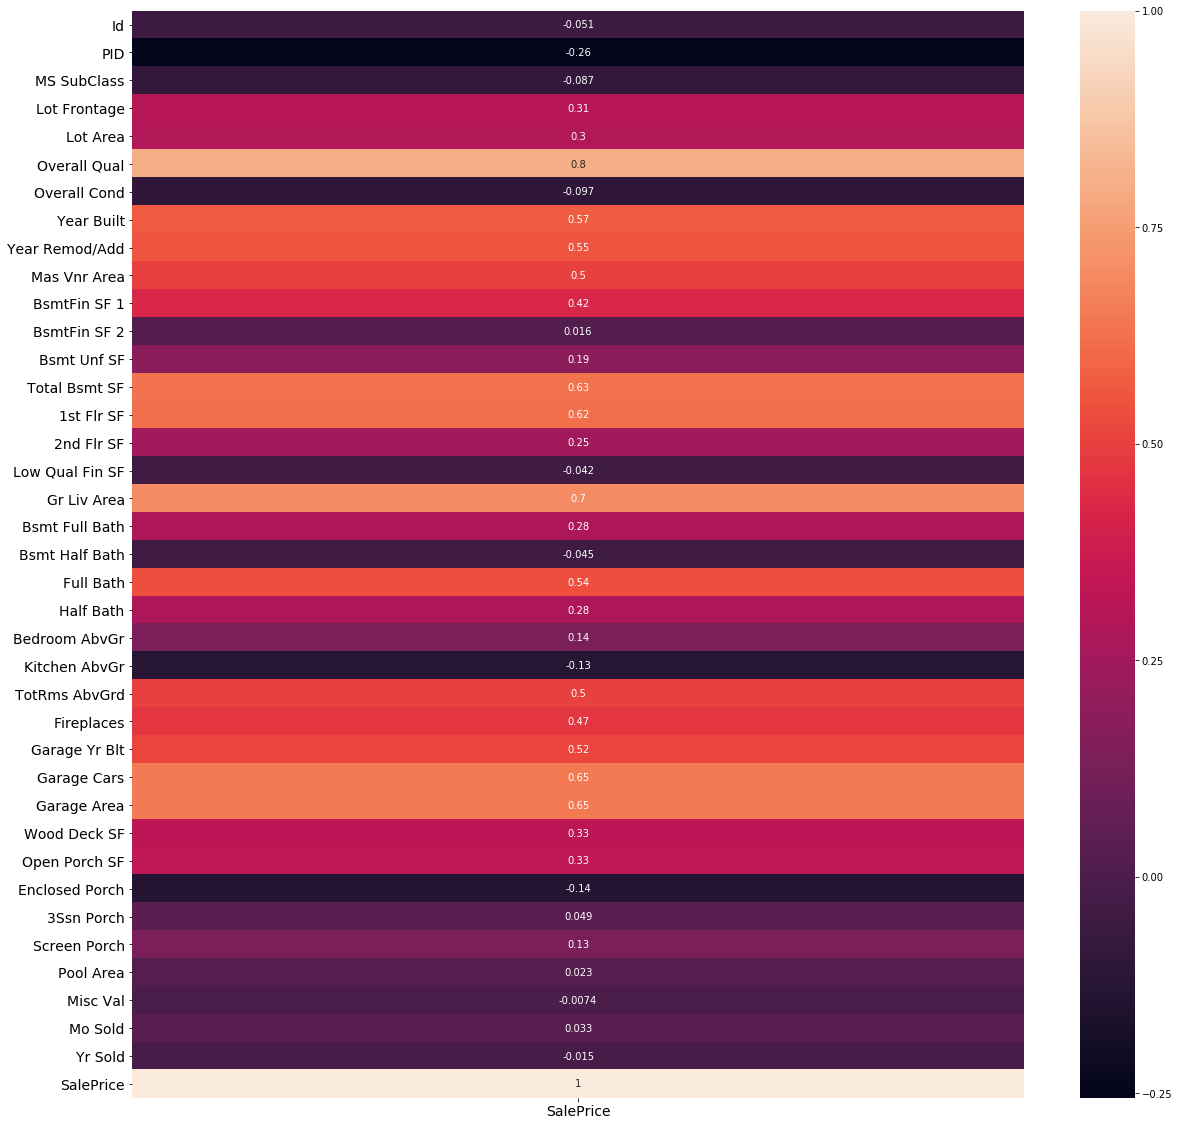

In [72]:
# Generate a heatmap in seaborn.

# Set the default matplotlib figure size to 12x12:
fix, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(num_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(num_train.corr()[['SalePrice']],  ax = ax, annot = True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.savefig('../images/correlation.png')
# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

_Obviously, all the columns don't fit onto a heatmap that fits onto the screen._ 

## Recommendations for Modeling

_Perhaps the best features to look into might be the ones that have a high correlation (either positive or negative) to SalePrice. Here is a closer look at the correlation numbers_

In [67]:
num_train.corr().loc['SalePrice']

Id                -0.051398
PID               -0.255052
MS SubClass       -0.087335
Lot Frontage       0.312748
Lot Area           0.296566
Overall Qual       0.800207
Overall Cond      -0.097019
Year Built         0.571849
Year Remod/Add     0.550370
Mas Vnr Area       0.503579
BsmtFin SF 1       0.423856
BsmtFin SF 2       0.016432
Bsmt Unf SF        0.190861
Total Bsmt SF      0.629303
1st Flr SF         0.618486
2nd Flr SF         0.248452
Low Qual Fin SF   -0.041594
Gr Liv Area        0.697038
Bsmt Full Bath     0.283332
Bsmt Half Bath    -0.045290
Full Bath          0.537969
Half Bath          0.283001
Bedroom AbvGr      0.137067
Kitchen AbvGr     -0.125444
TotRms AbvGrd      0.504014
Fireplaces         0.471093
Garage Yr Blt      0.516111
Garage Cars        0.647781
Garage Area        0.649897
Wood Deck SF       0.326490
Open Porch SF      0.333476
Enclosed Porch    -0.135656
3Ssn Porch         0.048732
Screen Porch       0.134581
Pool Area          0.023106
Misc Val          -0

_Numerical Features that have a absolute correlation of 0.4 or greater are the following:_

In [68]:
[col for col, x in zip(num_train.columns, num_train.corr().loc['SalePrice']) if x > 0.4 or x < -0.4]

['Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'SalePrice']

### _These features are the ones that might be good to look into first._
- 'Overall Qual',
- 'Year Built',
- 'Year Remod/Add',
- 'Mas Vnr Area',
- 'BsmtFin SF 1',
- 'Total Bsmt SF',
- '1st Flr SF',
- 'Gr Liv Area',
- 'Full Bath',
- 'TotRms AbvGrd',
- 'Fireplaces',
- 'Garage Yr Blt',
- 'Garage Cars',
- 'Garage Area'